# Naive Bayes Classifier

In a naive Bayes Classifier we attempt to differentiate between classes using Bayesian probability. What makes this approach naive is that we assume that the observation (sometimes referred to as the probability of the evidence given the hypothesis) is made up of independent features. 

This notebook presents the use of such classifier to classify a handwritten digit as being one of the numbers 0-9. For this process, the images are binarized to have a value of either 0 or 1 by setting a threshold. Then we will treat each pixel in the 28 x 28 image as a feature, and by doing so we will be have all the information we need to calculate the posterior probability of an image of a digit belonging to a certain class given it exhibits features `X`. in other words, we will calculate the probability of an image being a digit `D` given it has certain pixels on and others off.


The formula for the probability of $D$ given $X$ is:
$$
P(D \mid X) = \frac{P(X \mid D) \cdot P(D)}{P(X)}
$$


In our classifier, we don't need to use the denominator. We will calculate the the probabilities for all classes and choose whichever is highest without needing to normalize the probability to be a value from $0-1$. Thus we will have that:


$$
P(D \mid X)  \propto {P(X \mid D) \cdot P(D)}
$$

Since we are assuming independence, the probability of $X$ given $D$ can be expressed as the multiplication of all conditional probabilities from $X_1$ to $X_n$ given $D$:

$$
P(X \mid D) = \prod_{i=1}^n P(X_i \mid D)
$$

With $X_i$ being pixel number $i$. Then the formula becomes:

$$
P(D | X) \propto P(D) \prod_{i=1}^n P(X_i | D)
$$


In [1]:
# define necessary imports
import numpy as np
import matplotlib.pyplot as plt
from utilities import train_test_split

In [2]:
# load images and labels
data = np.load("images_array.npy")
labels = np.load("labels_array.npy")
labels = labels.astype(np.int64)

# reshape images 
data = data.reshape(60_000, 28, 28)


### Binarizing Images
The pixel values in this image are in the range $[0,1]$, we will binarize the pixel values to be either $0$ or $1$ with the following rule:
$0 \space if \space X_i < 0.5 \space else \space  1$.

After this operation, we have: $X_i \in  0, 1$.

The purpose of this transformation is to simplify our classification process. When we try to classify an image, the classifier will go through each pixel and calculate the probability of that image being a certain digit given it has a pixel of value 1 or 0. Another option we can try is to divide the pixel values into more categories (e.g. 0-0.2, 0.2-0.4, 0.4-0.6, 0.6-0.8, etc)


![original vs binarized image](orig_vs_binarized.png)
image source: CSC 4444 course slides


In [3]:
def binarize_images(array):
    """
    Convert image array into ones and zeros.
    if arr[i,j] < 0.5 then arr[i, j] = 0
    else arr[i, j] = 1 
    """
    zeros_loc = np.where(array < 0.5)
    array[zeros_loc] = 0
    ones_loc = np.where(array >= 0.5)
    array[ones_loc] = 1
    

binarize_images(data)

In [4]:
# Split into training and test sets.
x_train, y_train, x_test, y_test = train_test_split(data, labels, 0.95)

One can image stacking all of the images in our training set in order from digits $0 - 9$. Then for each pixel we would sum the total value of the pixels at that position of all the images in the class and divide it by the number of images in the class and this would result in the conditional probability of an image having pixel $i$ being $1$ given it belongs to a certain class of digit $D$. For example, for pixel $X_1$ assume the number of pixels set to $1$ for $D = 3$ are $200$ and the number of images in the class $D = 3$ is $700$ then

$ P(X_1 \mid D=3) = \frac{300}{700} $

The prior probability is a straightforward calculation using the same approach. 



In [5]:
def fit(x_train, y_train, k=1):
    """
    Calculate the prior probabilities and the probability distribution of each pixel value being 1 given
    it belongs to a certain class. Returns priors and probability distribution arrays
    """

    # Calculate the prior probability of the class appearing.
    # also apply laplace smoothing
    
    n = 2 # vocabulary for laplace smoothing
    # n = np.unique(x_train).size
    indices = {x: np.where(y_train == x) for x in range(10)} # Get rows of where each class is
    probs = np.zeros(shape=(10, 28, 28))
    priors = np.zeros(shape = (10))

    for i in range(10):
        arr = x_train[indices[i]]
        # fill in priors array with the number of samples for each class
        priors[i] = arr.shape[0]
        # sum over axis 0
        pixel_sum = np.sum(arr == 1, axis = 0) 
        num_samples = arr.shape[0]  
        probs[i] = (pixel_sum + k) / (num_samples + k*n) # (pixels sum + k) / (num_samples + k*n) for laplace smoothing



    priors = priors / x_train.shape[0] # divide by the total length of the array
    # in order to get the prob of each class occurring
    return priors, probs
    print(priors)


In [25]:
# This would be my fit function
# Calculate the prior probability of the class appearing.
# also apply laplace smoothing
k = 0.01 # a lower values of k gives better performance than a value of k >= 1
n = 2
indices = {x: np.where(y_train == x) for x in range(10)} # Get rows of where each class is
probs = np.zeros(shape=(10, 28, 28))
priors = np.zeros(shape = (10))

for i in range(10):
    arr = x_train[indices[i]]
    # fill in priors array with the number of samples for each class
    priors[i] = arr.shape[0]
    # sum over axis 0
    pixel_sum = np.sum(arr == 1, axis = 0) 
    num_samples = arr.shape[0]  
    probs[i] = (pixel_sum + k) / (num_samples + k*n) # (pixels sum + k) / (num_samples + k*n) for laplace smoothing



priors = priors / x_train.shape[0] # divide by the total length of the array
                                    # in order to get the prob of each class occurring
print("The priors are: ", priors)


The priors are:  [0.09821757 0.11278195 0.09944442 0.101828   0.09737631 0.09055856
 0.09842789 0.10464974 0.0975691  0.09914647]


### Application of Laplace Smoothing

A problem that might not be easily spotted at first sight is that we can calculate a probability (erroneously) to be zero if one of the terms is zero. 
Consider the case of a pixel position that is set to zero everywhere, then the conditional porobability of that pixel being $1$ given it belong to a certain digit  $D$ would be zero and it would make the posterior probability zero no matter what the other conditional probabilities of other features are.

To solve this problem we apply a technique known as Laplace smoothing. In this case, we will have a $k$ value which will determine how many pixels of value $1$ we add. We will also have to correct for this in the denominator by adding $kn$ to the number of samples. $n$ is referred to as the vocabulary and it is the number of values that this feature can take on, in our case, each pixel can only take on the values of $1$ and $0$ which makes $n = 2$ as is seen in the code block above whose main function is to calculate and create an array to store the priors of belonging to each class.

Note that k does not need to be an integer.




$$
P(X_i \mid  D) = \frac{pixel_i + k}{imgCount + kn}
$$



### Calculation of Probability Distributions

For a given image we will calculate the probability that it is a certain digit given it exhibits features $X$. We will store this distribution in an array of 10 values. The index of the array corresponds to the digit. In other words If `arr[i]` equals the probability that the image belongs to class `i`.


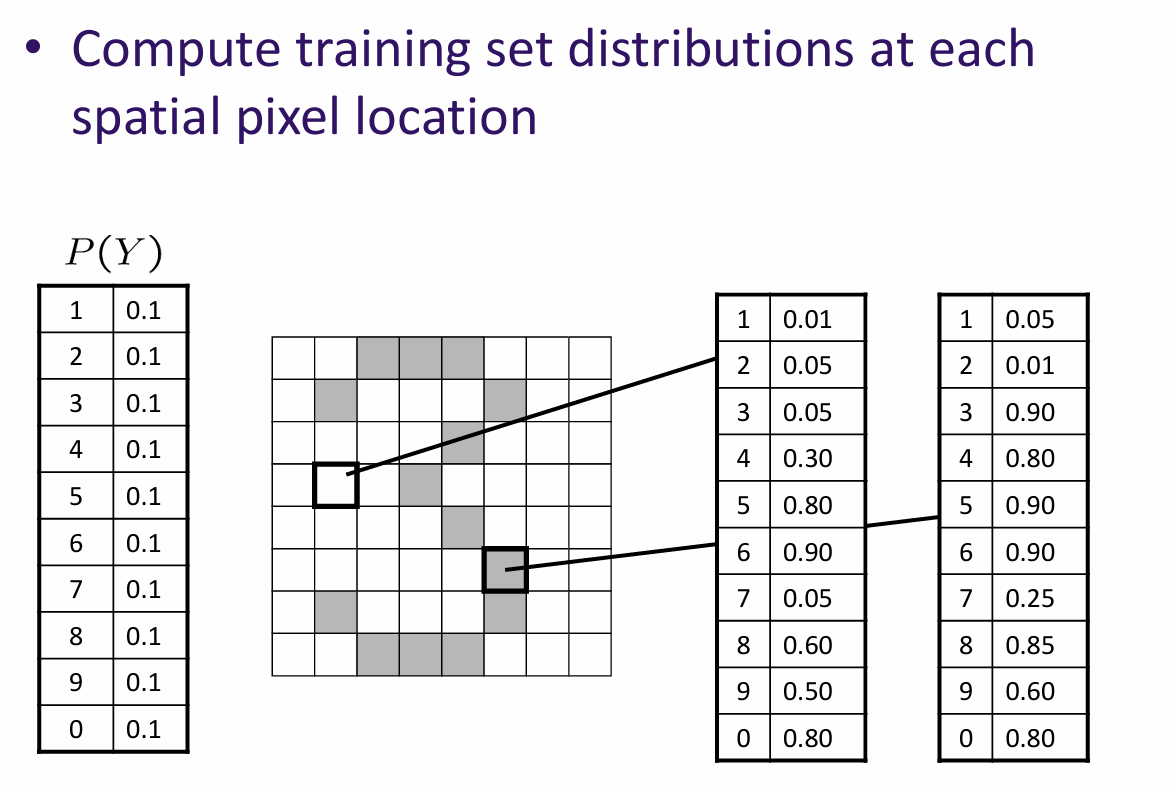

Image source: CSC 4444 course slides

In [21]:
# Calculate all proability distributions of belonging to a certain class for a specific image

i = 20
lab = y_test[i]
img = x_test[i]

# 

priors, probs = fit(x_train, y_train)
def calc_all_probs(img, probs, priors):
    # get indices where img pixel value is 1 and where it's 0
    on = np.where(img == 1)
    off = np.where(img == 0)

    # take the product over the columns
    # unpack the indices and use fancy indexing 
    # to get an array of all elements in index 0 where the pixel is activated
    # this will calculate the observation, also known as the probability of 
    # the evidence given the hypothesis.
    observation = np.prod(probs[:, *on], axis = 1) * np.prod(1 - probs[:, *off], axis = 1)
    result = priors * observation
    return result


p = calc_all_probs(img, probs, priors)    
p

array([2.24538021e-148, 5.07633121e-180, 7.51352419e-117, 1.37370777e-090,
       4.67772986e-131, 2.65220333e-116, 2.52700460e-188, 2.51016325e-130,
       1.96510846e-100, 2.65772504e-137])

In [26]:
# calculate accuracy for all images in the test set
incorrect_imgs = np.array([]).reshape(0, 28)
correct_labels = []
predicted_labels = []

incorrect = 0
correct = 0
total = 0
# go through all the images in the test set
for i in range(len(x_test)):
    img = x_test[i]
    predicted = np.argmax(calc_all_probs(img, probs, priors))
    actual = y_test[i]
    if predicted == actual:
        correct += 1
    else:
        incorrect_imgs = np.concat([incorrect_imgs, img], axis=0)
        correct_labels.append(y_test[i])
        predicted_labels.append(predicted)
        incorrect += 1
    total += 1
    # if incorrect  > 20: 
    #     break
print(correct / total)


0.8403333333333334


This model results in an accuracy of $84\%$

In [27]:
incorrect_imgs = incorrect_imgs.reshape(incorrect, 28, 28)

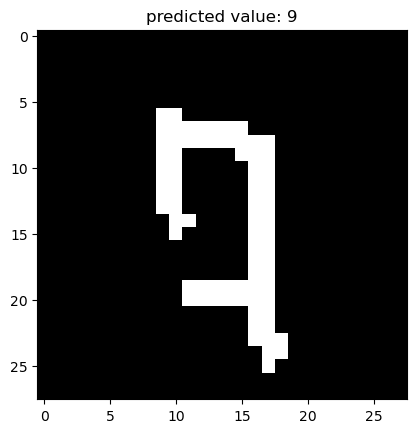

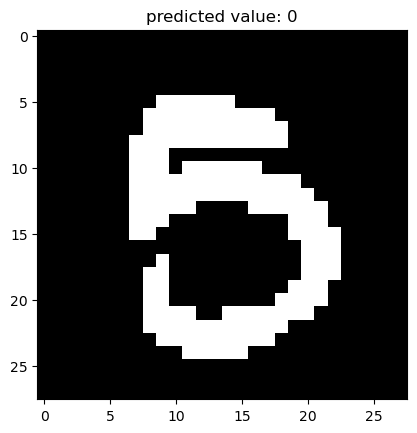

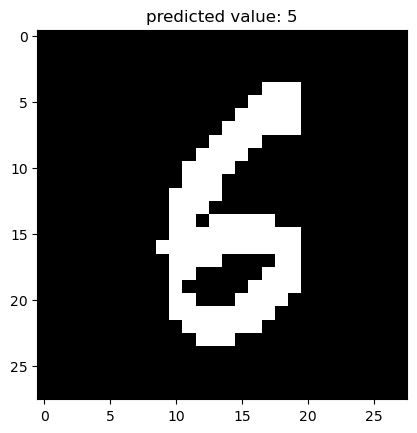

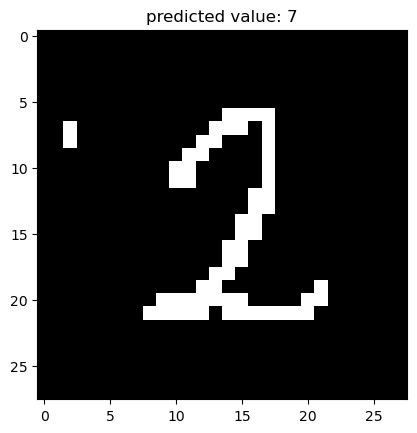

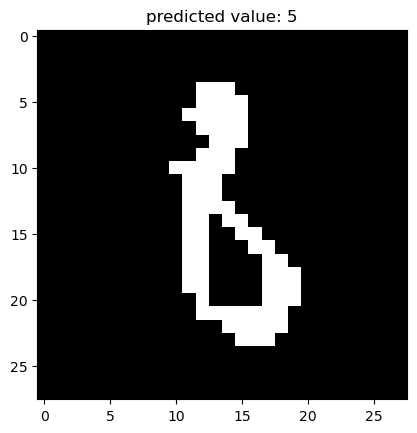

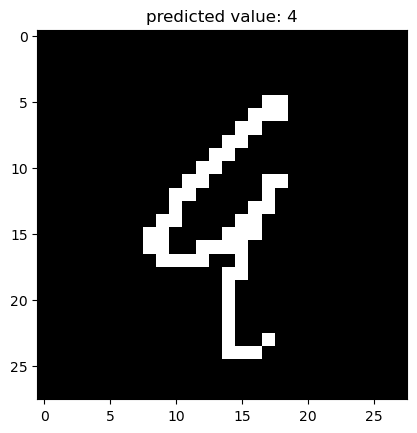

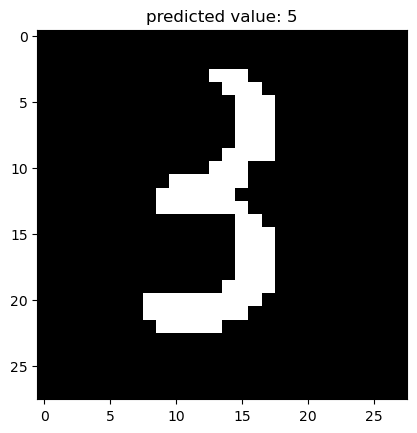

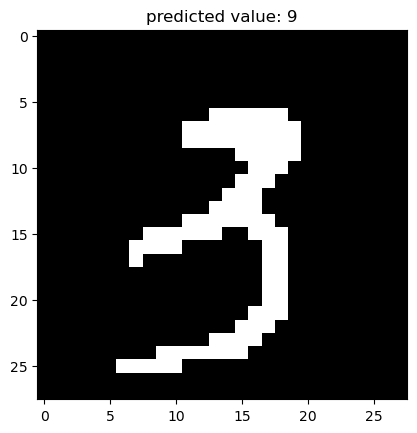

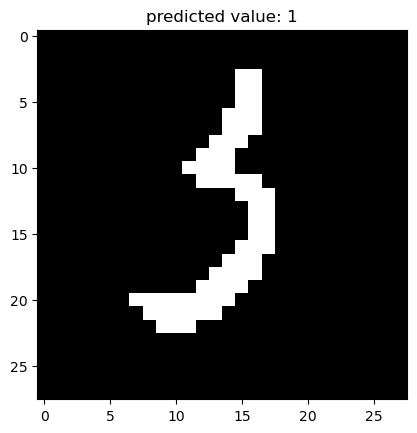

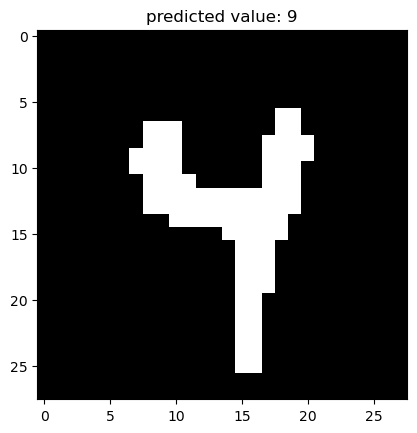

<Figure size 640x480 with 0 Axes>

In [28]:
# some images that were incorrecly classified
for x in range(10):
    plt.title(f"predicted value: {predicted_labels[x]}")
    plt.imshow(incorrect_imgs[x], cmap='grey')
    plt.figure()